In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import copy
import seaborn as sns


## Part 1: London’s underground resilience


### I. Topological network

#### I.1. Centrality measures

In [2]:
# Read the data
# G = nx.from_pandas_edgelist(df, 'station_origin', 'station_destination', ['distance'])
G = nx.read_graphml(
    'london.graph')


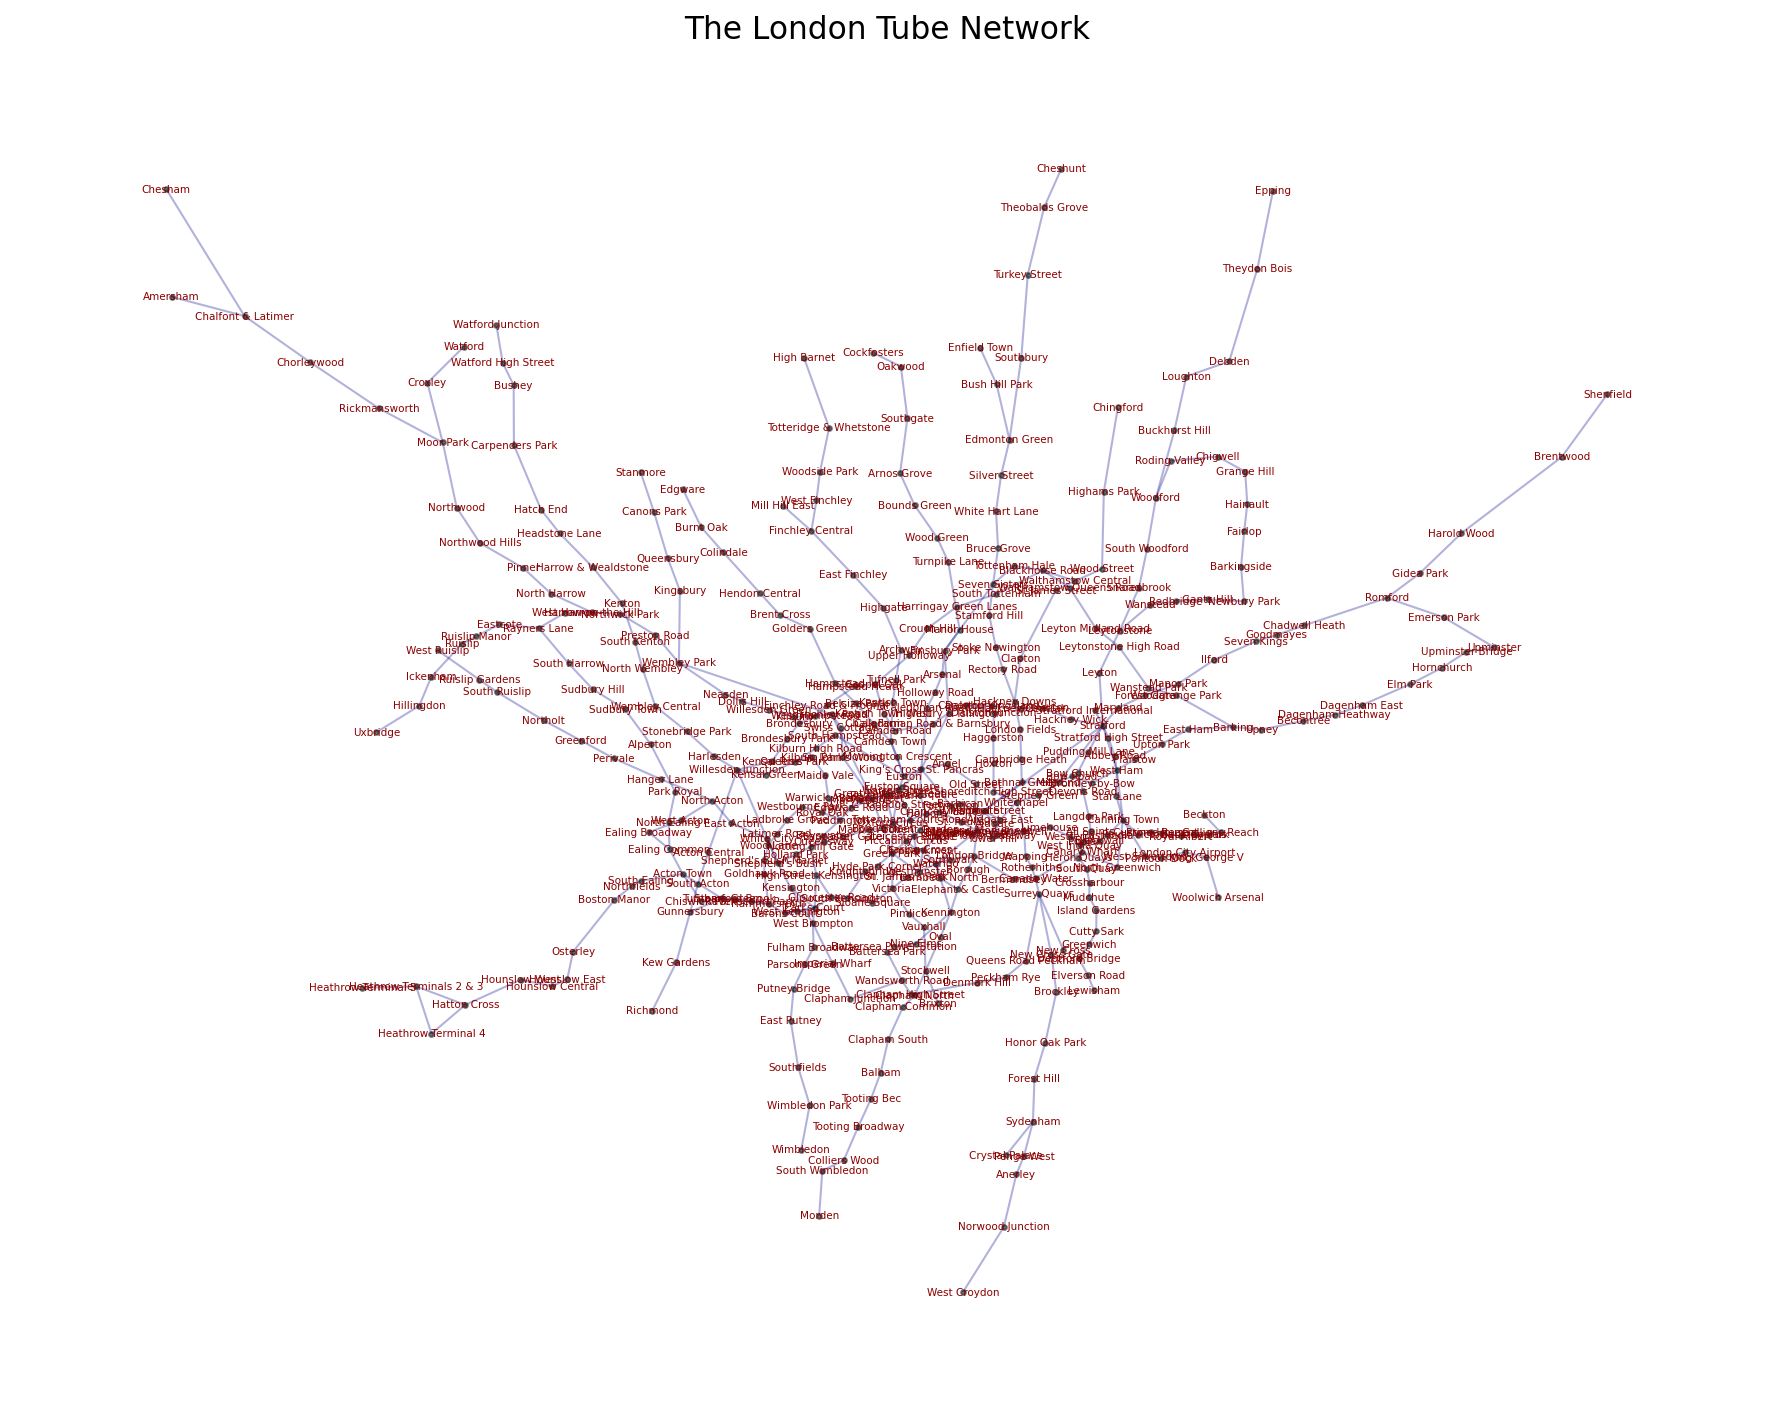

In [3]:
# Extract 'x' and 'y' values from 'coords' attribute
for node in G.nodes():
    coords = G.nodes[node]['coords'].split(',')
    G.nodes[node]['x'] = float(coords[0].strip("()"))
    G.nodes[node]['y'] = float(coords[1].strip("()"))

pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes()}
# pos = nx.spring_layout(G)
fig = plt.figure(figsize=(15, 12), dpi=150)
nx.draw_networkx_edges(G, pos, edge_color='darkblue', alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_size=5, node_color='black', alpha=0.5, label='Stations')
nx.draw_networkx_labels(G, pos, font_size=5, font_color='darkred')
plt.axis("off")
plt.title('The London Tube Network', fontsize=15)

plt.show()

In [4]:


# 从G中提取节点坐标数据
data = {'Node': [], 'X': [], 'Y': []}
for node in G.nodes():
    coords = G.nodes[node]['coords'].split(',')
    x = float(coords[0].strip("()"))
    y = float(coords[1].strip("()"))
    
    data['Node'].append(node)
    data['X'].append(x)
    data['Y'].append(y)

# 使用pandas创建DataFrame
df = pd.DataFrame(data)

# 显示DataFrame
print(df)

# 如果需要，你还可以将DataFrame保存为CSV文件
df.to_csv('node_coordinates.csv', index=False)


                    Node              X              Y
0               Uxbridge  505605.791642  184156.711920
1             Hillingdon  507544.858885  185008.645505
2               Ickenham  508089.808480  185937.754438
3                Ruislip  509483.214375  187013.512216
4          Ruislip Manor  510118.873687  187242.513489
..                   ...            ...            ...
396  London City Airport  542238.832638  180292.585933
397              Brixton  531052.373453  175421.812275
398             Vauxhall  530418.542904  177894.234301
399              Pimlico  529721.854750  178312.503952
400       Tottenham Hale  534502.007197  189513.418871

[401 rows x 3 columns]


In [5]:
def df_to_markdown(df, index=True, header=True):
    markdown_str = ""
    if header:
        markdown_str += "| Rank |" if index else "| "
        markdown_str += "| ".join(df.columns) + " |\n"
        markdown_str += "| " + " | ".join(["---"] * (len(df.columns) + (1 if index else 0))) + " |\n"
    for i, row in df.iterrows():
        if index:
            markdown_str += "| " + str(i)
        for col in df.columns:
            markdown_str += " | " + row[col]
        markdown_str += " |\n"
    return markdown_str


In [6]:
# calculate 3 centrality measures for each node
deg_cen = nx.degree_centrality(G.copy())
bet_cen = nx.betweenness_centrality(G.copy())
# eig_cen = nx.eigenvector_centrality(G)
clo_cen = nx.closeness_centrality(G.copy())

# convert the results to a DataFrame and sort
deg_cen_df = pd.DataFrame(list(deg_cen.items()), columns=['station', 'degree_centrality'])
deg_cen_df = deg_cen_df.sort_values('degree_centrality', ascending=False).reset_index(drop=True)

bet_cen_df = pd.DataFrame(list(bet_cen.items()), columns=['station', 'betweenness_centrality'])
bet_cen_df = bet_cen_df.sort_values('betweenness_centrality', ascending=False).reset_index(drop=True)

clo_cen_df = pd.DataFrame(list(clo_cen.items()), columns=['station', 'closeness_centrality'])
clo_cen_df = clo_cen_df.sort_values('closeness_centrality', ascending=False).reset_index(drop=True)

# # Print the top 10 nodes for each centrality measure
# print("Top 10 ranked nodes for Degree Centrality:\n", deg_cen_df.head(10))
# print("\nTop 10 ranked nodes for Betweenness Centrality:\n", bet_cen_df.head(10))
# print("\nTop 10 ranked nodes for Closeness Centrality:\n", clo_cen_df.head(10))


# Create new columns with the desired format 'station (value)'
deg_cen_df['degree_centrality_formatted'] = deg_cen_df['station'] + ' (' + deg_cen_df['degree_centrality'].round(
    4).astype(str) + ')'
bet_cen_df['betweenness_centrality_formatted'] = bet_cen_df['station'] + ' (' + bet_cen_df[
    'betweenness_centrality'].round(4).astype(str) + ')'
clo_cen_df['closeness_centrality_formatted'] = clo_cen_df['station'] + ' (' + clo_cen_df['closeness_centrality'].round(
    4).astype(str) + ')'

# Merge dataframes
merged_df = pd.concat([deg_cen_df['degree_centrality_formatted'],
                       bet_cen_df['betweenness_centrality_formatted'],
                       clo_cen_df['closeness_centrality_formatted']], axis=1)

# Rename columns
merged_df.columns = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']

# Set the index to start from 1
merged_df.index = merged_df.index + 1

# # Generate markdown output
# print("Top 10 ranked nodes for 3 Centrality Measurements\n")
# print(df_to_markdown(merged_df, index=True, header=True))

# Display the merged dataframe
merged_df
merged_df.to_csv('merged_df.csv', index=False)

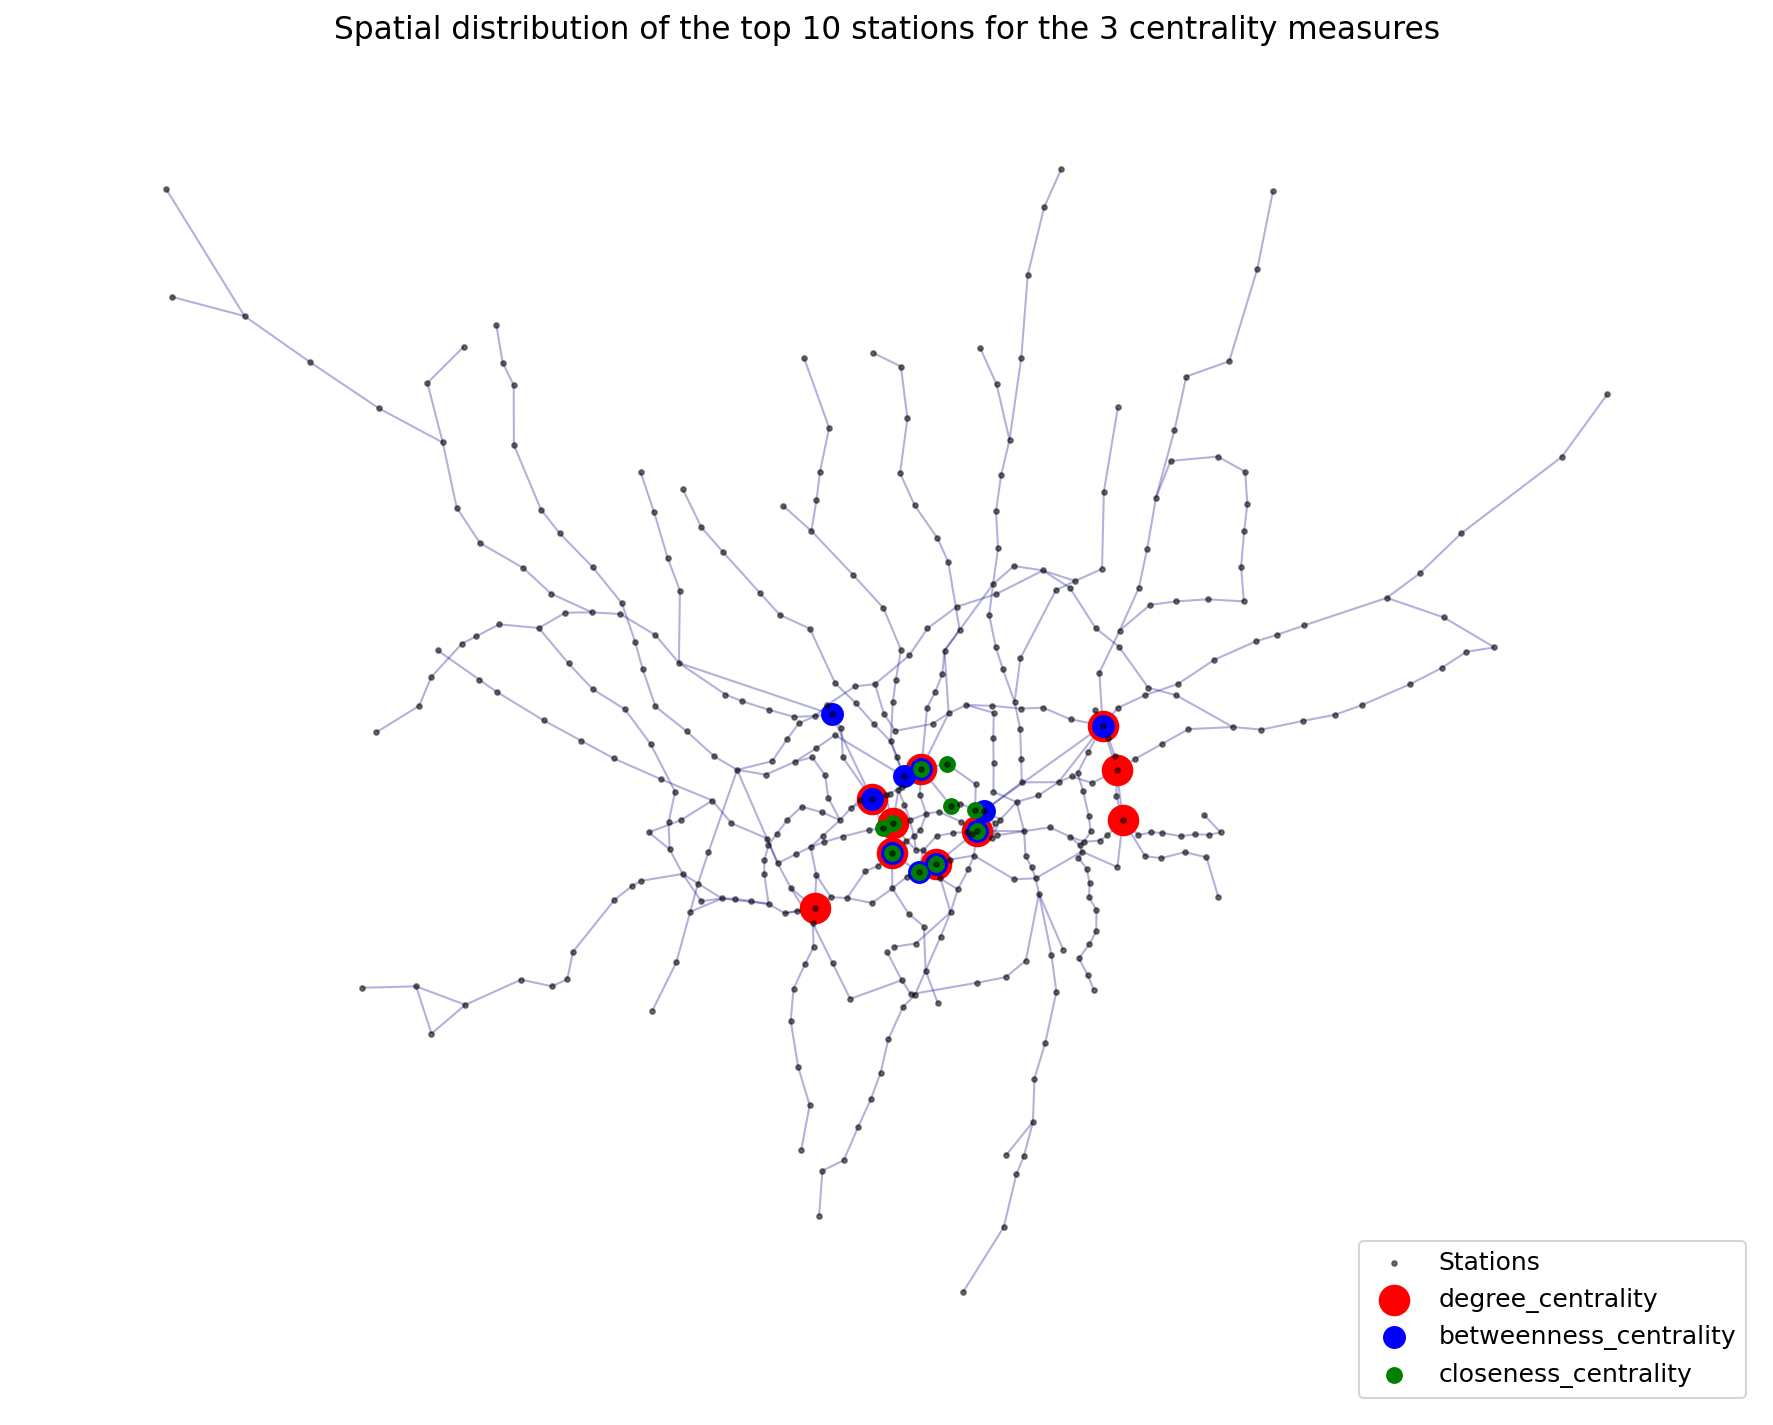

In [7]:
# Define color and size for each centrality measure
colors = ['red', 'blue', 'green']
sizes = [200, 100, 50]

# Create a scatter plot of the stations
fig, ax = plt.subplots(figsize=(15, 12), dpi=150)

# # Plot the London tube map as a background
nx.draw_networkx_edges(G, pos, edge_color='darkblue', alpha=0.3)
nx.draw_networkx_nodes(G, pos, node_size=5, node_color='black', alpha=0.5, label='Stations')

# Loop through the top 10 stations for each centrality measure
for i, df in enumerate([deg_cen_df.head(10), bet_cen_df.head(10), clo_cen_df.head(10)]):
    # Get the x and y coordinates of each station
    x = [G.nodes[node]['x'] for node in df['station']]
    y = [G.nodes[node]['y'] for node in df['station']]

    # Plot the stations as a scatter plot with different color and size for each centrality measure
    ax.scatter(x, y, color=colors[i], s=sizes[i], label=df.columns[1])

# Add a title and legend to the plot
plt.title('Spatial distribution of the top 10 stations for the 3 centrality measures', fontsize=15)
plt.legend(loc='lower right', fontsize=12)

# Hide the axis and show the plot
plt.axis('off')
plt.show()


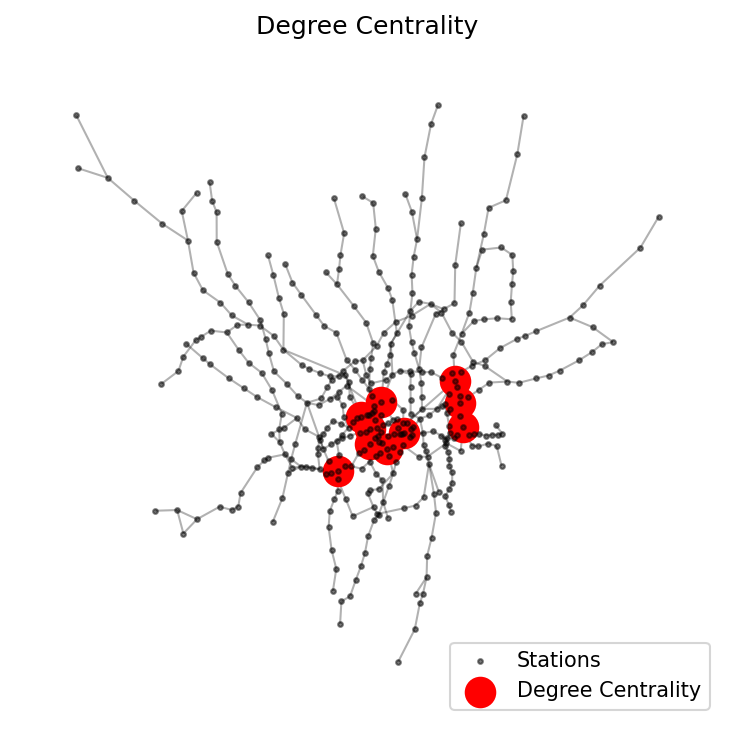

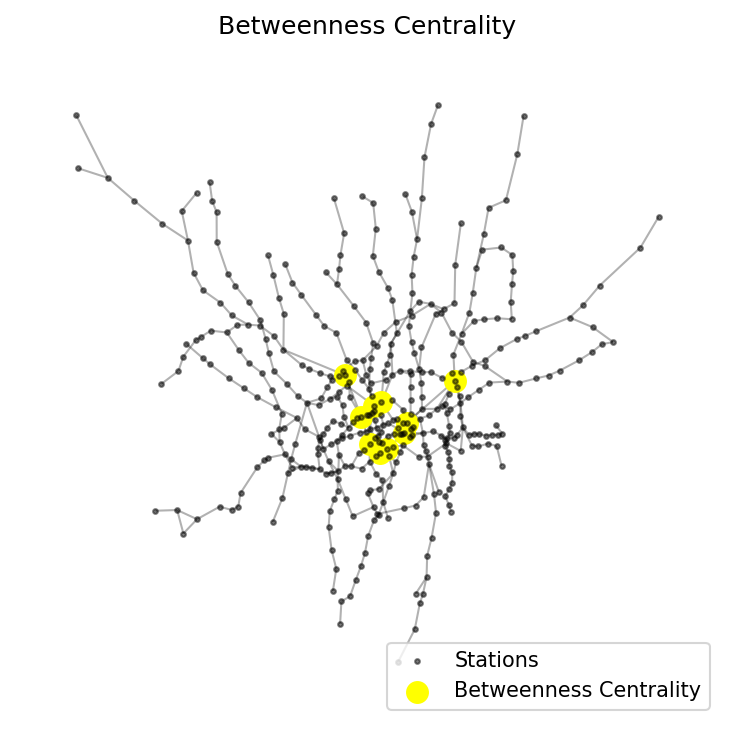

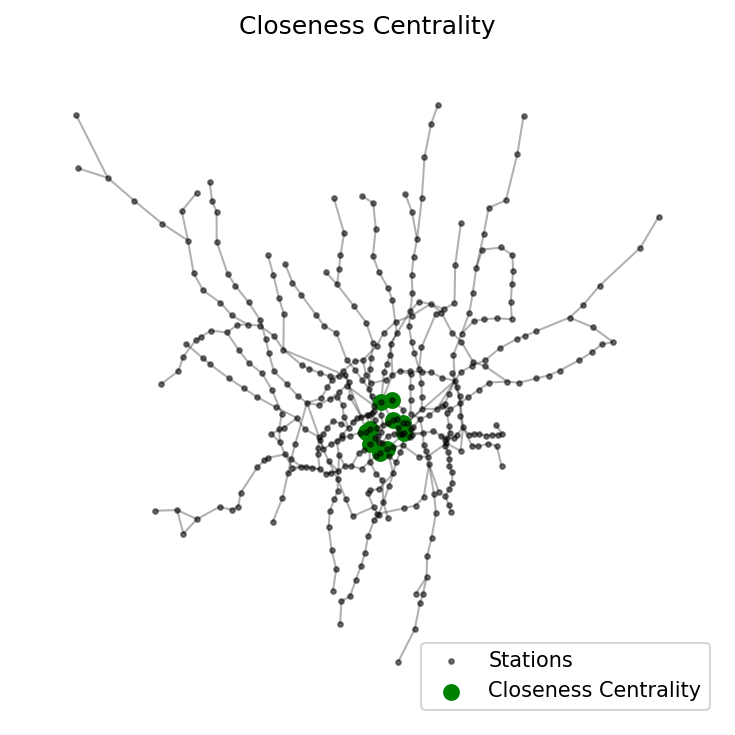

In [8]:
# Define color and size for each centrality measure
colors = ['red', 'yellow', 'green']
sizes = [200, 100, 50]
labels = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']

dfs = [deg_cen_df.head(10), bet_cen_df.head(10), clo_cen_df.head(10)]

# Loop through the top 10 stations for each centrality measure
for i, df in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

    # Plot the London tube map as a background for each plot
    nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.3, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_size=5, node_color='black', alpha=0.5, label='Stations', ax=ax)

    # Get the x and y coordinates of each station
    x = [G.nodes[node]['x'] for node in df['station']]
    y = [G.nodes[node]['y'] for node in df['station']]
    
    # Plot the stations as a scatter plot with different color and size for the centrality measure
    ax.scatter(x, y, color=colors[i], s=sizes[i], label=labels[i])

    # # Draw station names
    # top_station_labels = {station: station for station in df['station']}
    # nx.draw_networkx_labels(G, pos, labels=top_station_labels, font_size=10, ax=ax)

    # Add a title and legend to the plot
    ax.set_title(labels[i], fontsize=12)
    ax.legend(loc='lower right', fontsize=10)
    ax.axis('off')

    # Show and save the plot
    plt.tight_layout()
    plt.show()
    # Uncomment the next line if you wish to save the figure.
    # fig.savefig(f"{labels[i]}.png")


#### I.2. Impact measures

In [9]:
# Create a function to compute the number of connected components in the network after node removal
def count_connected_components(G):
    G_copy = copy.deepcopy(G)
    return len(list(nx.connected_components(G_copy)))


# Create a function to compute the size of the largest connected component in the network after node removal
def size_largest_component(G):
    G_copy = copy.deepcopy(G)
    components = list(nx.connected_components(G_copy))
    largest_component = max(components, key=len)
    return len(largest_component)

#
def global_efficiency(G):
    G_copy = copy.deepcopy(G)
    return nx.global_efficiency(G_copy)


#### I.3. Node removal

In [10]:
def weighted_node_removal_impact(G, node):
    # Create a copy of the graph and remove the specified node
    G_copy = G.copy()
    G_copy.remove_node(node)

    # Calculate the total flow in the original network
    total_flow = sum([G.edges[u, v]['flows'] for u, v in G.edges()])

    # Calculate the total flow in the modified network
    modified_total_flow = sum([G_copy.edges[u, v]['flows'] for u, v in G_copy.edges()])

    # Calculate the percentage reduction in total flow due to node removal
    reduction_percentage = ((total_flow - modified_total_flow) / total_flow)

    return reduction_percentage

In [11]:
# calculate the modified impact measure for each node and store the result in a dictionary
modified_impact_measures = {}
for node in G.nodes():
    modified_impact_measures[node] = weighted_node_removal_impact(G.copy(), node)
    # print(f"Removing {node} would reduce total flow by {modified_impact_measures[node]:.2f}%")

# sort the nodes by their impact measures in descending order
# sorted_nodes = sorted(modified_impact_measures.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_nodes_df = pd.DataFrame(sorted(modified_impact_measures.items(), key=lambda x: x[1], reverse=True),
                               columns=['station', 'impact'])
sorted_nodes_df['impact'] = sorted_nodes_df['impact'].apply(lambda x: f"{x:.2%}")

# # print the top 10 nodes with highest impact measures
# print(
#     "Top 10 nodes with highest impact measures:\n(The percentage reduction in total traffic caused by the removal of one of the stations)\n")
#
# for i, (node, impact) in enumerate(sorted_nodes[:10]):
#     print(f"Top {i + 1}: {node}: {impact:.2f}%")
#
# Set the index to start from 1
sorted_nodes_df.index = sorted_nodes_df.index + 1

# Generate markdown output
# print(
#     "Top 10 nodes with highest impact measures:\n(The percentage reduction in total traffic caused by the removal of one of the stations)\n")
# print(df_to_markdown(sorted_nodes_df, index=True, header=True))

# Display the sorted nodes dataframe
sorted_nodes_df

,station,impact
1,Bank and Monument,7.14%
2,Green Park,6.43%
3,Waterloo,5.82%
4,King's Cross St. Pancras,4.82%
5,Westminster,4.35%
...,...,...
397,Abbey Road,0.01%
398,Cheshunt,0.00%
399,Battersea Park,0.00%
400,Battersea Power Station,0.00%


In [12]:
# 1. Merge the centrality dataframes and reduction impact into one DataFrame
full_df = deg_cen_df.merge(bet_cen_df[['station', 'betweenness_centrality']], on='station', how='outer')
full_df = full_df.merge(clo_cen_df[['station', 'closeness_centrality']], on='station', how='outer')
full_df = full_df.merge(sorted_nodes_df[['station', 'impact']], on='station', how='outer')

# Convert impact back to float for calculations
full_df['impact'] = full_df['impact'].str.rstrip('%').astype('float') / 100.0

# 2. Calculate RF_i for each station
full_df['RF_i'] = 0.25 * full_df['degree_centrality'] + \
                  0.25 * full_df['closeness_centrality'] + \
                  0.25 * full_df['betweenness_centrality'] + \
                  0.25 * full_df['impact']

# Sort by RF_i to get the most influential nodes at the top
final_df = full_df[['station', 'RF_i']].sort_values(by='RF_i', ascending=False).reset_index(drop=True)
final_df.to_csv('final_df.csv', index=False)
# 3. Present the top 10 nodes with the highest RF_i values in a table
print(final_df.head(10))


                    station      RF_i
0         Bank and Monument  0.123865
1                 Stratford  0.115457
2          Liverpool Street  0.109640
3  King's Cross St. Pancras  0.108613
4                  Waterloo  0.107346
5                Green Park  0.102478
6               Westminster  0.092346
7                    Euston  0.091814
8              Baker Street  0.087532
9      Highbury & Islington  0.075848


In [13]:
# def nonseq_removal(G, centrality_measure, num_nodes=10):
#     G_removal = copy.deepcopy(G)
#     # Compute centrality measure for all nodes in the network
#     node_centrality = centrality_measure(G_removal)

#     # Create a DataFrame with nodes and their centrality scores
#     nodes_df = pd.DataFrame(list(node_centrality.items()), columns=['node', 'centrality'])

#     # Sort nodes by their centrality score
#     nodes_sorted = nodes_df.sort_values(by='centrality', ascending=False)

#     # Initialize lists to store the impact measures for each node removal
#     num_components = []
#     largest_component_size = []
#     num_components.append(count_connected_components(G_removal))
#     largest_component_size.append(size_largest_component(G_removal))

#     # Remove nodes in order of decreasing centrality score and compute impact measures
#     for i in range(min(num_nodes, len(nodes_sorted))):
#         node = nodes_sorted.iloc[i]['node']
#         G_copy = copy.deepcopy(G_removal)
#         G_copy.remove_node(node)
#         num_components.append(count_connected_components(G_removal))
#         largest_component_size.append(size_largest_component(G_removal))

#     return num_components, largest_component_size, num_nodes


# def seq_removal(G, centrality_measure, num_nodes=10):
#     G_removal = copy.deepcopy(G)
#     # Initialize lists to store the impact measures for each node removal
#     num_components = []
#     largest_component_size = []
#     num_components.append(count_connected_components(G_removal))
#     largest_component_size.append(size_largest_component(G_removal))
#     # Continue removing nodes until 10 nodes have been removed
#     for i in range(min(num_nodes, len(G_removal.nodes))):
#         # Compute centrality measure for all nodes in the network
#         node_centrality = centrality_measure(G_removal)

#         # Create a DataFrame with nodes and their centrality scores
#         nodes_df = pd.DataFrame(list(node_centrality.items()), columns=['node', 'centrality'])

#         # Sort nodes by their centrality score
#         nodes_sorted = nodes_df.sort_values(by='centrality', ascending=False)

#         # Remove the highest ranked node and compute impact measures
#         node = nodes_sorted.iloc[0]['node']
#         G_removal.remove_node(node)
#         num_components.append(count_connected_components(G_removal))
#         largest_component_size.append(size_largest_component(G_removal))

#     return num_components, largest_component_size, num_nodes


In [14]:
# #Define the centrality measures to use
# centrality_measures = [nx.degree_centrality, nx.betweenness_centrality, nx.closeness_centrality]

# # Initialize lists to store results for each centrality measure
# ns_num_components = []
# ns_largest_component_size = []
# seq_num_components = []
# seq_largest_component_size = []

# # Perform node removal for each centrality measure using both non-sequential and sequential strategies
# for centrality_measure in centrality_measures:
#     # Perform non-sequential removal
#     ns_components, ns_size, ns_nodes = nonseq_removal(G, centrality_measure, 200)
#     ns_num_components.append(ns_components)
#     ns_largest_component_size.append(ns_size)

#     # Perform sequential removal
#     seq_components, seq_size, seq_nodes = seq_removal(G, centrality_measure, 200)
#     seq_num_components.append(seq_components)
#     seq_largest_component_size.append(seq_size)

# #Loading the data
# G = copy.deepcopy(G)

# # Set a color palette
# sns.set_palette("mako_r")

# # Plot the impact measures for each strategy and centrality measure in one plot
# plt.figure(figsize=(10, 8))
# for i in range(len(centrality_measures)):
#     plt.plot(ns_largest_component_size[i], label=f'NS - {centrality_measures[i].__name__} LCS')
#     plt.plot(seq_largest_component_size[i], label=f'Seq - {centrality_measures[i].__name__} LCS')
#     plt.plot(ns_num_components[i], linestyle='--', label=f'NS - {centrality_measures[i].__name__} NCC')
#     plt.plot(seq_num_components[i], linestyle='--',
#              label=f'Seq - {centrality_measures[i].__name__} NCC')
# plt.legend(loc='upper right')
# plt.title(f'Impacts of removaling {ns_nodes} nodes')
# plt.xlabel('Nodes Removed')
# plt.ylabel('Impact Measure')
# plt.grid(False)
# plt.gcf().set_facecolor('none')
# plt.legend()

# plt.show()

# # Plot the impact measures for each strategy and centrality measure for better understanding and analysis
# plt.figure(figsize=(10, 8))
# for i in range(len(centrality_measures)):
#     plt.subplot(3, 2, 2 * i + 1)
#     plt.plot(ns_largest_component_size[i], label='Non-sequential')
#     plt.plot(seq_largest_component_size[i], label='Sequential')
#     plt.title(f'Largest Component Size ({centrality_measures[i].__name__})')
#     plt.xlabel('Nodes Removed')
#     # plt.ylabel('Size of Largest Component')
#     plt.legend()
#     plt.grid(False)
#     plt.gcf().set_facecolor('none')

#     plt.subplot(3, 2, 2 * i + 2)
#     plt.plot(ns_num_components[i], label='Non-sequential')
#     plt.plot(seq_num_components[i], label='Sequential')
#     plt.title(f'Number of Components ({centrality_measures[i].__name__})')
#     plt.xlabel('Nodes Removed')
#     # plt.ylabel('Number of Component')
#     plt.legend()
#     plt.grid(False)
#     plt.gcf().set_facecolor('none')

# plt.subplots_adjust(hspace=0.4)
# plt.show()



### II. Flows: weighted network

#### II.1
> Consider the centrality measure derived in I.- indicating the most relevant stations for assessing the vulnerability of the underground. What would you need to do to adjust this measure for a weighted network? Recompute the ranking of the 10 most important nodes according to this adjusted measure. Do you find the same ones as in I.1?

In [15]:
G = nx.read_graphml(
    'london.graph')


# Define the function for weighted degree centrality, with an optional 'weight' argument
def weighted_degree_centrality(G, weight):
    weighted_degrees = {}  # Initialize an empty dictionary to store the weighted degrees of nodes
    max_weighted_degree = 0  # Initialize the maximum weighted degree to 0

    # Loop through each node in the graph
    for node in G.nodes():
        # Calculate the weighted degree for the current node by summing the weights (e.g., 'flows') of its edges
        weighted_degree = sum([d.get(weight, 1) for _, _, d in G.edges(node, data=True)])
        weighted_degrees[node] = weighted_degree  # Store the weighted degree in the dictionary
        # Update the maximum weighted degree if the current weighted degree is larger
        max_weighted_degree = max(max_weighted_degree, weighted_degree)

    # Normalize the weighted degrees by dividing each weighted degree by the maximum weighted degree
    # This will result in a value between 0 and 1, representing the weighted degree centrality
    weighted_degree_centrality = {node: weighted_degree / max_weighted_degree for node, weighted_degree in
                                  weighted_degrees.items()}

    return weighted_degree_centrality  # Return the weighted degree centrality dictionary


# Invert the flows attribute to use as weights, with a small constant value to avoid division by zero
epsilon = 1e-6
for u, v, d in G.edges(data=True):
    d['inv_flows'] = 1 / (d['flows'] + epsilon)

# Compute the adjusted degree centrality
degree_centrality_weighted = weighted_degree_centrality(G, weight='flows')

# Compute the adjusted betweenness centrality using inv_flows as weights
betweenness_centrality_weighted = nx.betweenness_centrality(G, weight='inv_flows')

# Compute the adjusted closeness centrality using inv_flows as distances
closeness_centrality_weighted = nx.closeness_centrality(G, distance='inv_flows')

# Rank the nodes based on each measure
degree_ranked_weighted = sorted(degree_centrality_weighted.items(), key=lambda x: x[1], reverse=True)
betweenness_ranked_weighted = sorted(betweenness_centrality_weighted.items(), key=lambda x: x[1], reverse=True)
closeness_ranked_weighted = sorted(closeness_centrality_weighted.items(), key=lambda x: x[1], reverse=True)

# print("Top 10 ranked nodes for Degree Centrality in Weighted Network:")
# print(pd.DataFrame(degree_ranked_weighted, columns=['station', 'degree_centrality']))
# print("\nTop 10 ranked nodes for Betweenness Centrality in Weighted Network:")
# print(pd.DataFrame(betweenness_ranked_weighted, columns=['station', 'betweenness_centrality']))
# print("\nTop 10 ranked nodes for Closeness Centrality in Weighted Network:")
# print(pd.DataFrame(closeness_ranked_weighted, columns=['station', 'closeness_centrality']))

degree_ranked_weighted = pd.DataFrame(degree_ranked_weighted, columns=['station', 'degree_centrality'])
betweenness_ranked_weighted = pd.DataFrame(betweenness_ranked_weighted, columns=['station', 'betweenness_centrality'])
closeness_ranked_weighted = pd.DataFrame(closeness_ranked_weighted, columns=['station', 'closeness_centrality'])

# Create new columns with the desired format 'station (value)'
degree_ranked_weighted['degree_centrality_formatted'] = degree_ranked_weighted['station'] + ' (' + \
                                                        degree_ranked_weighted['degree_centrality'].round(
                                                            4).astype(str) + ')'
betweenness_ranked_weighted['betweenness_centrality_formatted'] = betweenness_ranked_weighted['station'] + ' (' + \
                                                                  betweenness_ranked_weighted[
                                                                      'betweenness_centrality'].round(4).astype(
                                                                      str) + ')'
closeness_ranked_weighted['closeness_centrality_formatted'] = closeness_ranked_weighted['station'] + ' (' + \
                                                              closeness_ranked_weighted['closeness_centrality'].round(
                                                                  4).astype(str) + ')'

# Merge dataframes
merged_weighted_df = pd.concat([degree_ranked_weighted['degree_centrality_formatted'],
                                betweenness_ranked_weighted['betweenness_centrality_formatted'],
                                closeness_ranked_weighted['closeness_centrality_formatted']], axis=1)

# Rename columns
merged_weighted_df.columns = ['Weighted Degree Centrality', 'Weighted Betweenness Centrality',
                              'Weighted Closeness Centrality']

# Set the index to start from 1
merged_weighted_df.index = merged_weighted_df.index + 1

# Generate markdown output
# print("Top 10 ranked nodes for 3 Weighted Centrality Measurements\n")
# print(df_to_markdown(merged_weighted_df, index=True, header=True))

# Display the merged dataframe
merged_weighted_df
merged_weighted_df.to_csv('merged_weighted_df.csv', index=False)


In [16]:
# 1. Create dataframes from adjusted centrality measures
deg_cen_weighted_df = pd.DataFrame(list(degree_centrality_weighted.items()), columns=['station', 'degree_centrality'])
bet_cen_weighted_df = pd.DataFrame(list(betweenness_centrality_weighted.items()), columns=['station', 'betweenness_centrality'])
clo_cen_weighted_df = pd.DataFrame(list(closeness_centrality_weighted.items()), columns=['station', 'closeness_centrality'])

# 2. Merge the adjusted centrality dataframes and reduction impact into one DataFrame
full_vf_df = deg_cen_weighted_df.merge(bet_cen_weighted_df[['station', 'betweenness_centrality']], on='station', how='outer')
full_vf_df = full_vf_df.merge(clo_cen_weighted_df[['station', 'closeness_centrality']], on='station', how='outer')
full_vf_df = full_vf_df.merge(sorted_nodes_df[['station', 'impact']], on='station', how='outer')

# Convert impact back to float for calculations (just in case it's not already in float format)
full_vf_df['impact'] = full_vf_df['impact'].str.rstrip('%').astype('float') / 100.0

# 3. Calculate VF_i for each station
full_vf_df['VF_i'] = 0.25 * full_vf_df['degree_centrality'] + \
                  0.25 * full_vf_df['closeness_centrality'] + \
                  0.25 * full_vf_df['betweenness_centrality'] + \
                  0.25 * (1 - full_vf_df['impact'])

# Sort by VF_i to get the most vulnerable nodes at the top
final_vf_df = full_vf_df[['station', 'VF_i']].sort_values(by='VF_i', ascending=False).reset_index(drop=True)
final_vf_df.to_csv('final_vf_df.csv', index=False)
# 4. Present the top 10 nodes with the highest VF_i values in a table
print(final_vf_df.head(10))



                    station      VF_i
0         Bank and Monument  0.613848
1                Green Park  0.596268
2                  Waterloo  0.545670
3               Westminster  0.485131
4          Liverpool Street  0.474240
5  King's Cross St. Pancras  0.462157
6                 Stratford  0.455149
7                    Euston  0.437174
8              Baker Street  0.414562
9             Oxford Circus  0.411124


In [17]:
import pandas as pd

# Your provided code for RF and VF goes here...

# After calculating final_df and final_vf_df...

# 5. Merge final_df (RF_i values) and final_vf_df (VF_i values) on 'station'
merged_df = final_df.merge(final_vf_df[['station', 'VF_i']], on='station', how='outer')

# 6. Calculate the desired expression for each station
alpha = 0.25
beta = 0.25
merged_df['Result'] = alpha * merged_df['RF_i'] + beta * merged_df['VF_i']

# 7. Sort by 'Result' to get the stations with the highest combined values at the top
result_df = merged_df[['station', 'Result']].sort_values(by='Result', ascending=False).reset_index(drop=True)

# 8. Present the top 10 stations with the highest combined values in a table

result_df.to_csv('station_results.csv', index=False)


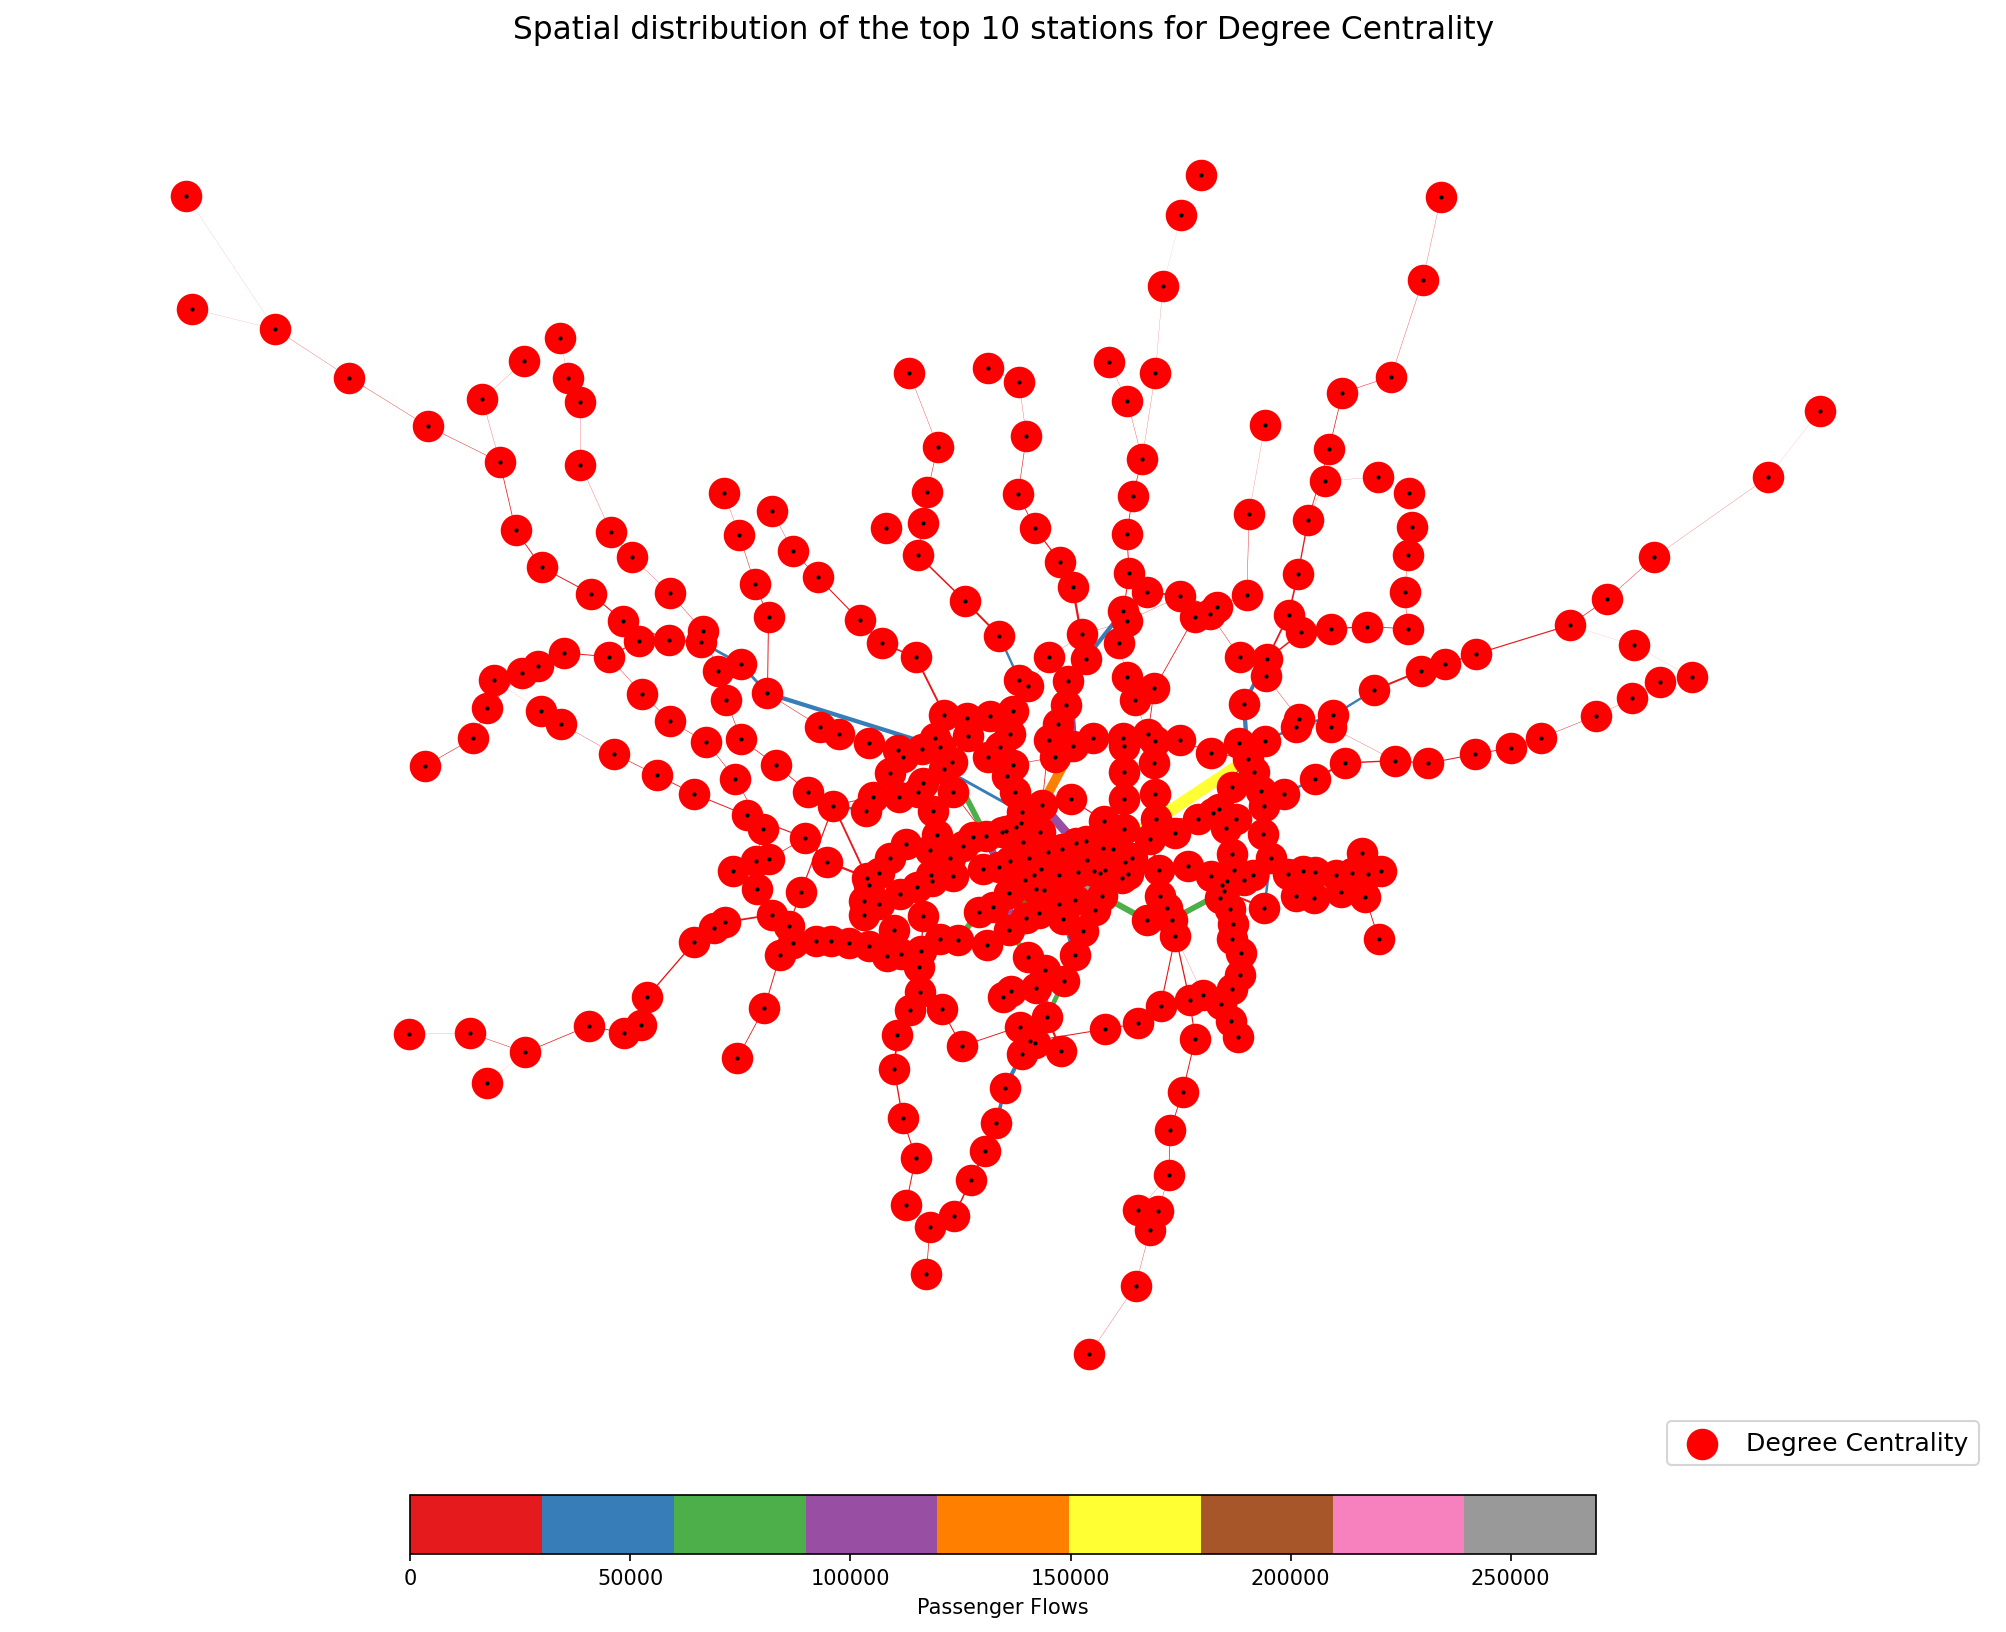

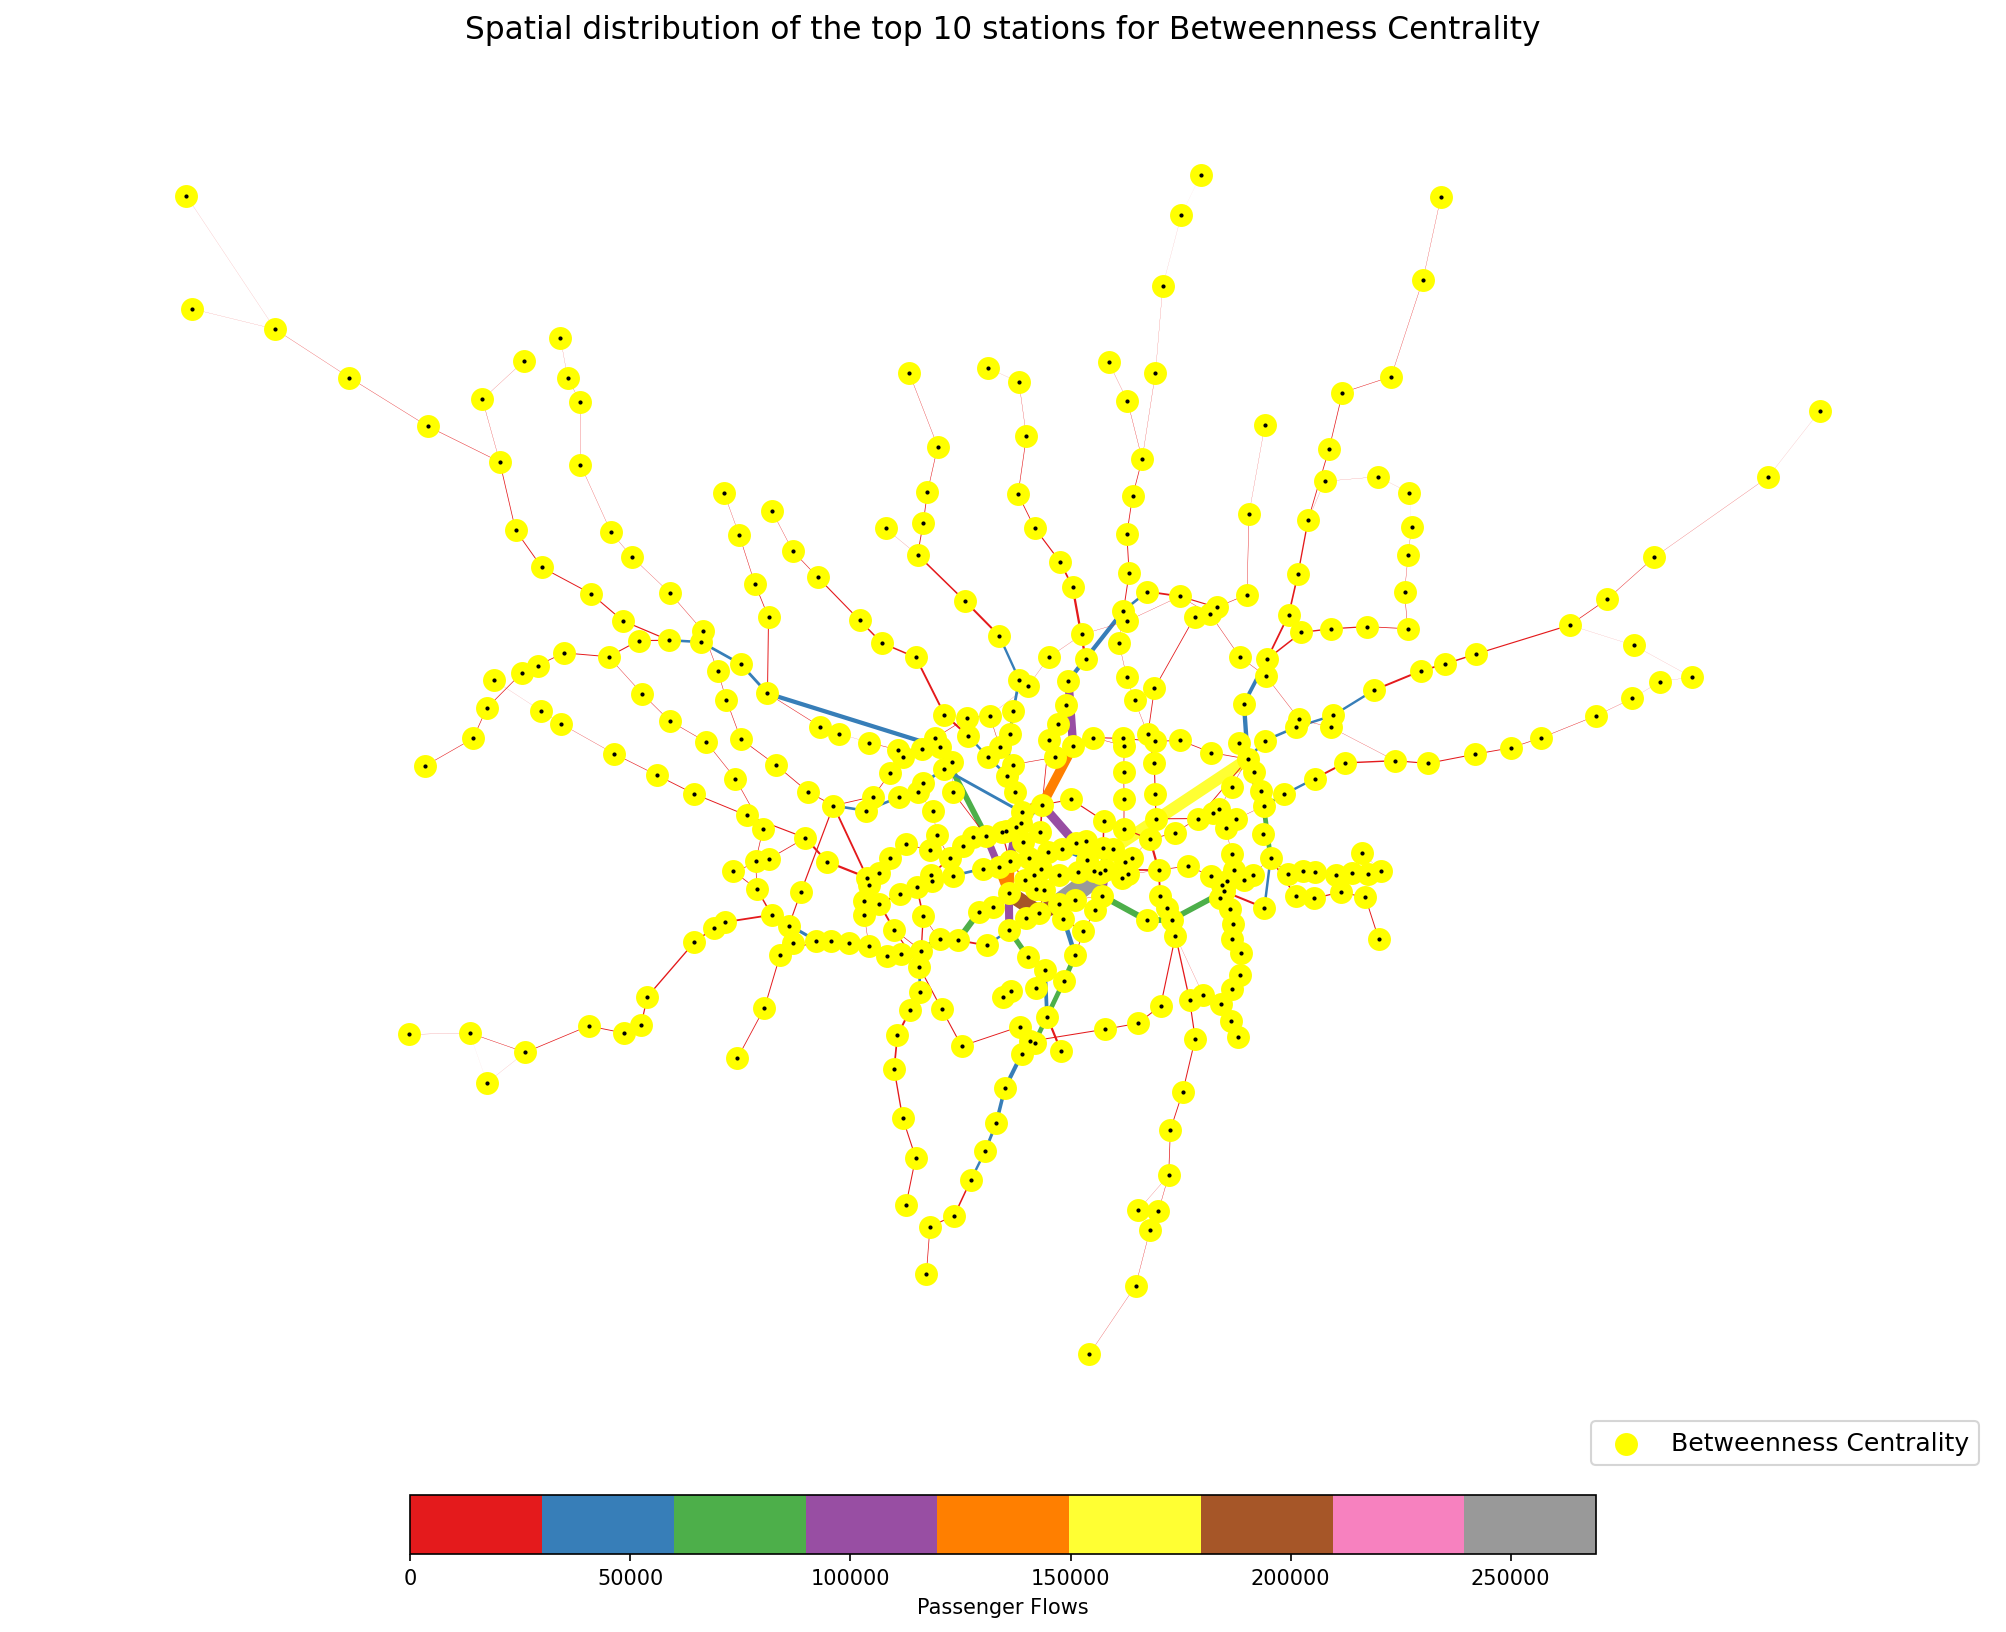

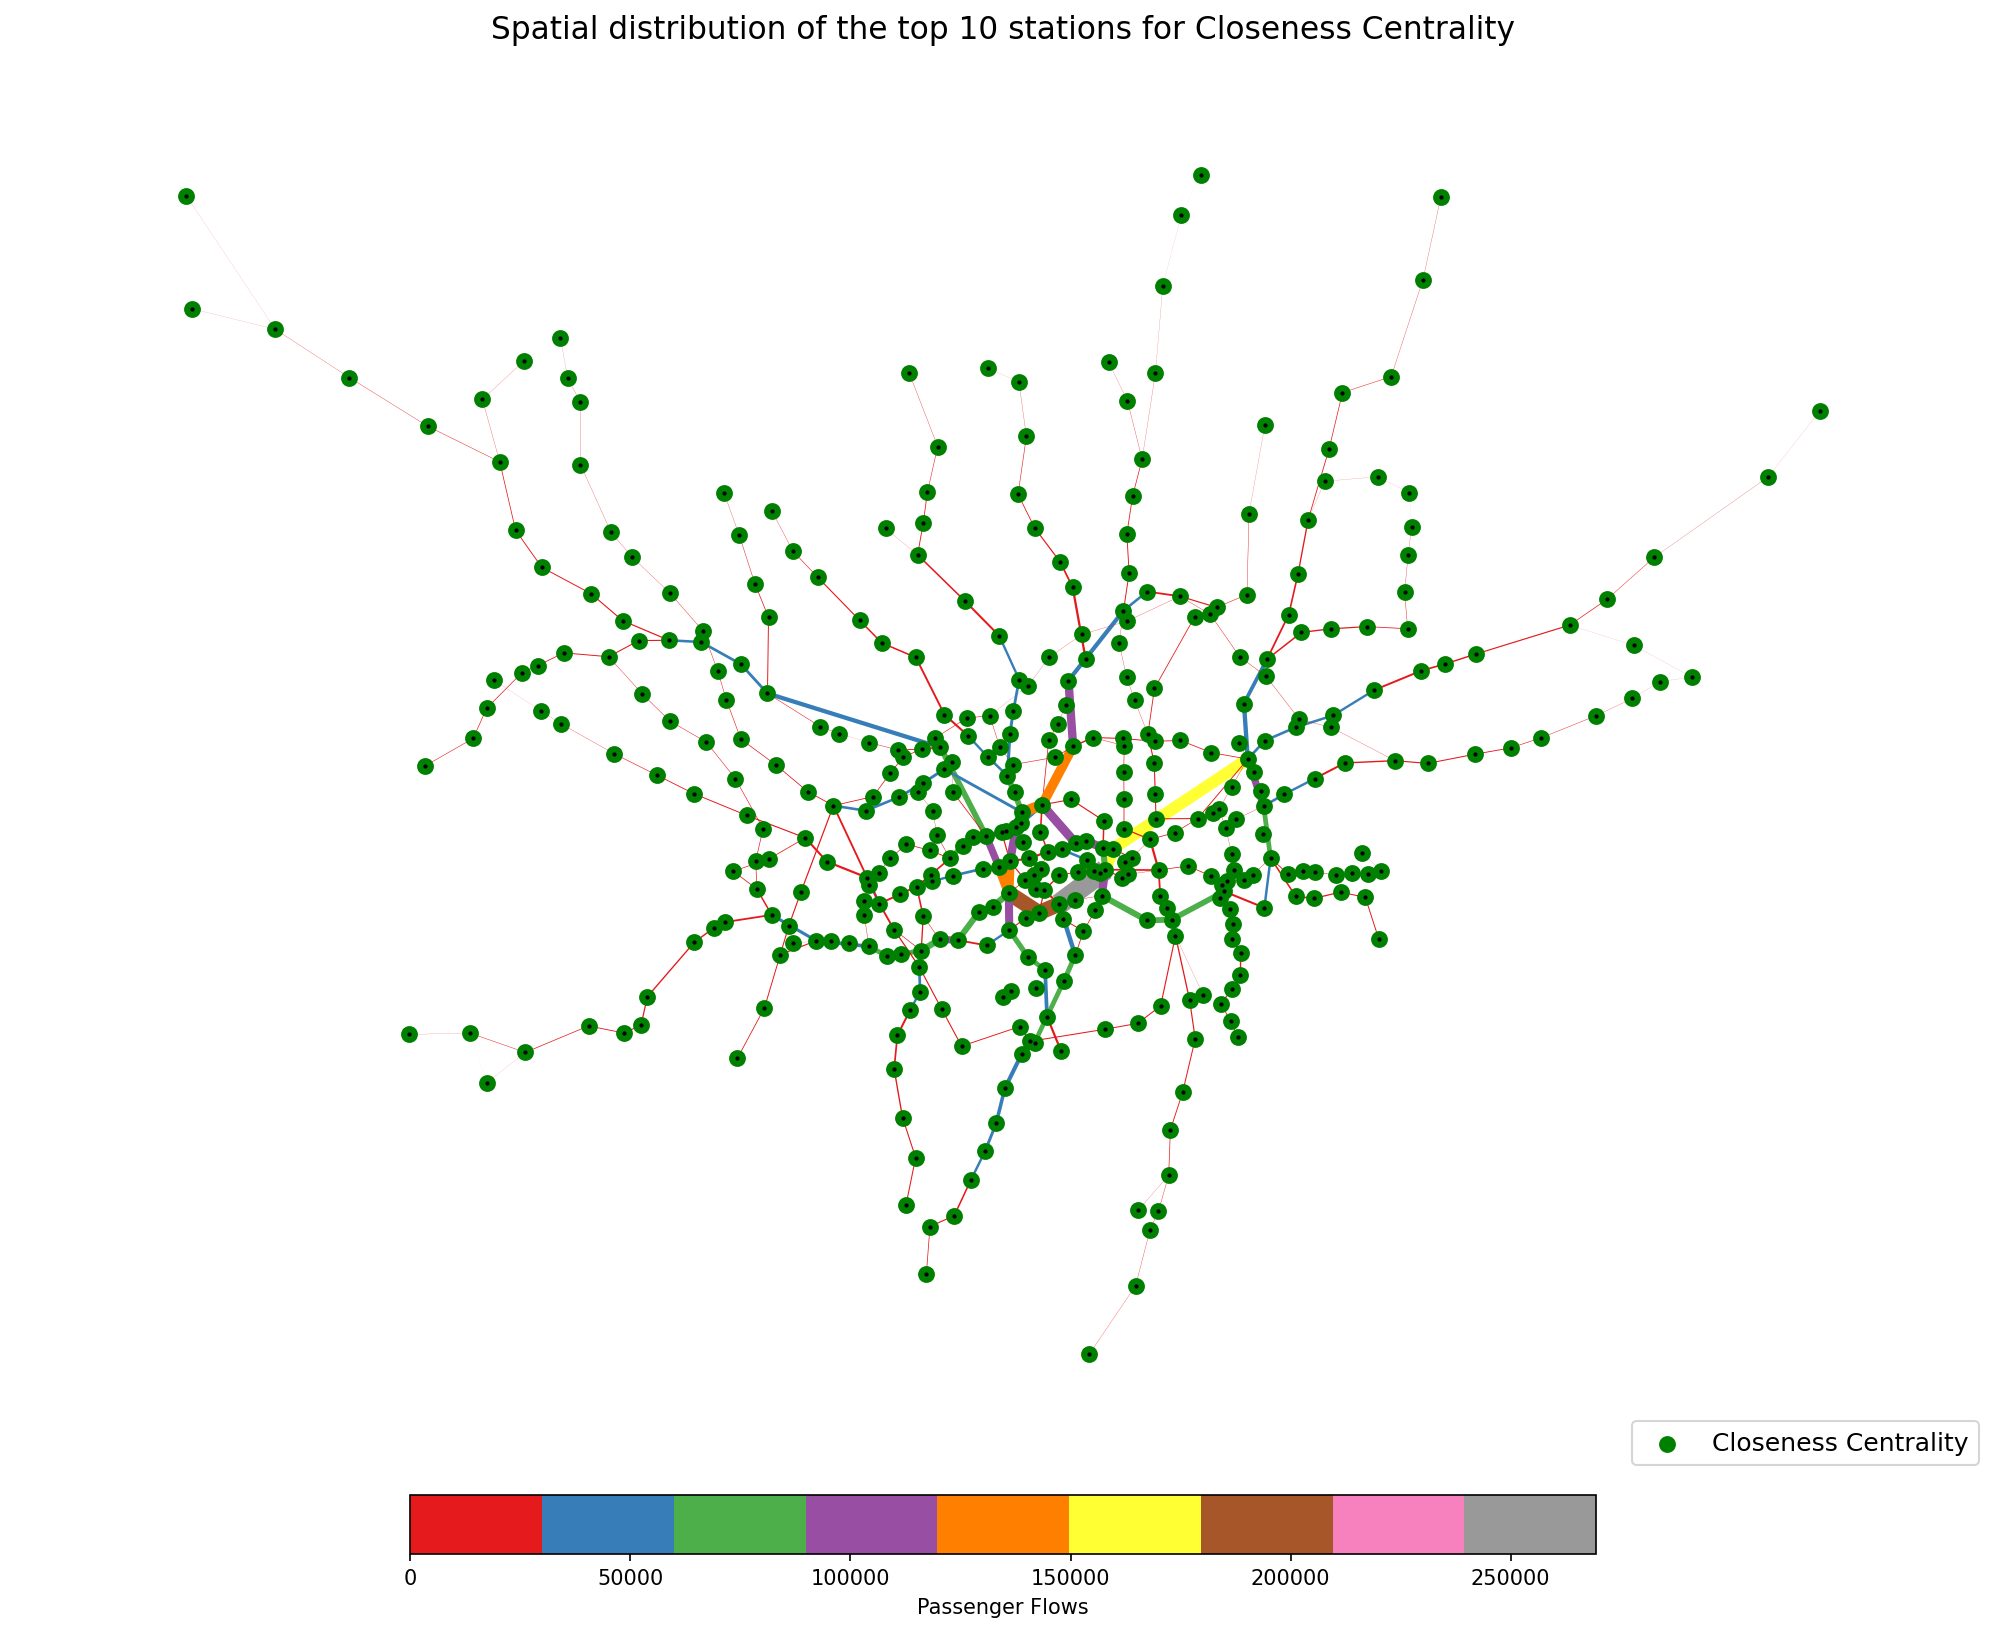

In [18]:
# Extract 'x' and 'y' values from 'coords' attribute
for node in G.nodes():
    coords = G.nodes[node]['coords'].split(',')
    G.nodes[node]['x'] = float(coords[0].strip("()"))
    G.nodes[node]['y'] = float(coords[1].strip("()"))

pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes()}
cmap = plt.cm.get_cmap("Set1")
flows_values = [data['flows'] for _, _, data in G.edges(data=True)]
flow_color = [cmap(i[2]['flows'] / max(flows_values)) for i in G.edges(data=True)]
flow_width = [(i[2]['flows'] / max(flows_values) * 10) for i in G.edges(data=True)]

# Define color and size for each centrality measure
colors = ['red', 'yellow', 'green']
sizes = [200, 100, 50]
labels = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']

dfs = [degree_ranked_weighted, betweenness_ranked_weighted, closeness_ranked_weighted]

# Loop through the top 10 stations for each centrality measure
for i, df in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(17, 15), dpi=150)

    # Draw edges representing flows between stations
    edg = nx.draw_networkx_edges(G, pos, edge_color=flow_color, width=flow_width)
    nx.draw_networkx_nodes(G, pos, node_color='black', node_size=1)

    # Draw the colorbar for the flows
    norm = plt.Normalize(min(flows_values), max(flows_values))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label="Passenger Flows", orientation="horizontal", shrink=0.6, pad=0.01)
    
    # Get the x and y coordinates of each station
    x = [G.nodes[node]['x'] for node in df['station']]
    y = [G.nodes[node]['y'] for node in df['station']]

    # Plot the stations as a scatter plot with different color and size for the centrality measure
    ax.scatter(x, y, color=colors[i], s=sizes[i], label=labels[i])

    # Add a title and legend to the plot
    plt.title(f'Spatial distribution of the top 10 stations for {labels[i]}', fontsize=15)
    plt.legend(loc='lower right', fontsize=12)

    # Hide the axis and show the plot
    plt.axis('off')
    plt.show()


III.1. Briefly introduce the spatial interaction models covered in the lectures using equations and defining the terms, taking particular care in explaining the role of the parameters.

III.2. Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter for the cost function (usually denoted as ). It is essential that you justify the model selected.